In [1]:
from model.rvae import RVAE
from util.batch_loader import Batch
from util.preprocess import Preprocess
from util.parameter import Parameter
from gensim.models import KeyedVectors
from torch.optim import Adam
import numpy as np
import torch

### load embedding model

In [2]:
embedding_model=KeyedVectors.load_word2vec_format('embedding.bin')

### or train an embedding model

In [3]:
from gensim.models import Word2Vec
import re
with open('train.txt','r') as f:
    data=f.read()
preprocess=Preprocess(embedding_model=embedding_model)
wash_sentences=preprocess.wash_data(data,save='train')

model=Word2Vec([re.split(r'[ ]+',sentence) for sentence in wash_sentences],300)
model.wv.save_word2vec_format('embedding.bin')

KeyboardInterrupt: 

In [ ]:
del wash_sentences,model

### load raw data

In [3]:
with open('train','r') as f:
    data=f.readlines()


### preprocess

In [4]:
import os
preprocess=Preprocess(embedding_model)
input=preprocess.to_sequence(data)
if not os.path.exists('embedding.npy'):
    embedding=preprocess.embedding()
    np.save('embedding',embedding)

### batch generator and parameter

In [5]:
batch_loader=Batch(input,0.7)
params=Parameter(word_embed_size=300,encode_rnn_size=600,latent_variable_size=1000,\
            decode_rnn_size=600,vocab_size=preprocess.vocab_size,embedding_path='embedding.npy')

### checkpoint

In [6]:
def save_checkpoint(state,  filename='checkpoint.pth.tar'):
    torch.save(state, filename)

### model , optimizer and train

In [7]:
model=RVAE(params)
optimizer=Adam(model.learnable_parameters(), 5e-4)

if os.path.isfile('checkpoint.pth.tar'):
    checkpoint=torch.load('checkpoint.pth.tar')
    optimizer.load_state_dict(checkpoint['optimizer'])
    i=checkpoint['i']
    model.i=i

train_step=model.trainer(optimizer)

if os.path.exists('trained_rvae'):
    model.load_state_dict(torch.load('trained_rvae'))
use_cuda=torch.cuda.is_available()
if use_cuda:
    model=model.cuda()
ce_list=[]
kld_list=[]
coef_list=[]

In [8]:
print(model)

RVAE (
  (encoder): Encoder (
    (highway): Highway (
    )
    (lstm): LSTM(300, 600, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder (
    (lstm): LSTM(1300, 600, batch_first=True)
    (fc): Linear (600 -> 13962)
  )
  (logvar): Linear (1200 -> 1000)
  (mu): Linear (1200 -> 1000)
  (embedding): Embedding (
    (word_embed): Embedding(13962, 300)
  )
)


In [9]:
model.i#=torch.autograd.Variable(torch.FloatTensor([1]),requires_grad=False)

Variable containing:
 1.5023e+05
[torch.FloatTensor of size 1]

### train

In [ ]:
test_batch=batch_loader.test_next_batch(1)
for j in range(100):
    for i,batch in enumerate(batch_loader.train_next_batch(32)):
        if i%501==0:
            sample=next(test_batch)
            print(' '.join([preprocess.index_to_word[i] for i in sample[0][0]]),'\n')
            sentence=model.sample(len(sample[0][0][::-1])+10,sample,use_cuda)
            sentence=[preprocess.index_to_word[i] for i in sentence]
            print(' '.join(sentence))
            continue
        ce,kld,coef=train_step(batch,0.2,use_cuda)
        if i%500==0:
            print('500 step: ce:{}, kld:{} '.format(ce,kld))
            torch.save(model.state_dict(), 'trained_rvae')
            print(model.i)
        ce_list+=[ce.cpu().numpy()[0]]
        kld_list+=[kld.cpu().numpy()[0]]
        coef_list+=[coef]
    print("epoch finish {}".format(j))
    np.save('ce',ce_list)
    np.save('kld',kld_list)
    np.save('coef',coef_list)
    save_checkpoint({
        'optimizer':optimizer.state_dict(),
        'i':model.i
    })
    with open('status','w') as f:
        f.write('echo {}'.format(j))
    !gsutil cp trained_rvae ce.npy kld.npy coef.npy status checkpoint.pth.tar gs://rvae

    

singles from other sites will also be attending 

spectacular multimedia village of the <ukn> palace next to the main <ukn> we 've lived southern california about
500 step: ce:
 0.6906
[torch.cuda.FloatTensor of size 1 (GPU 0)]
, kld:
 3.8091
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
Variable containing:
 1.5696e+05
[torch.FloatTensor of size 1]

the la weekly called the brewery the world 's largest artist in residence community 

bicycle ride time <ukn> the bike ride will take around # hour round
500 step: ce:
 0.5740
[torch.cuda.FloatTensor of size 1 (GPU 0)]
, kld:
 3.0199
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
Variable containing:
 1.5746e+05
[torch.FloatTensor of size 1]

to make it even more awesome <ukn> there are no neighbors within half of mile of the house 

this is <ukn> # hour tour hike in the morning
500 step: ce:
 0.3895
[torch.cuda.FloatTensor of size 1 (GPU 0)]
, kld:
 2.4288
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
Variable containing:
 1.5796e+05
[torch.F

| [6 files][244.6 MiB/244.6 MiB]                                                
Operation completed over 6 objects/244.6 MiB.                                    
the # film version starred jerry lewis and tony curtis <ukn> and the # tony winning revival featured bradley <ukn> <ukn> mark <ukn> <ukn> christine <ukn> <ukn> gina <ukn> and mary <ukn> # # price discount tickets <ukn> to get your discount ticket first sign up for goldstar by 

in recent years <ukn> los angeles <ukn> is led by la home for his mid single room and he has raised as he performs producing among among many times before he <ukn> <ukn> <ukn> best known for his innovative <ukn> the ultimate within the cool <ukn> starting
500 step: ce:
 0.9404
[torch.cuda.FloatTensor of size 1 (GPU 0)]
, kld:
 6.0112
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
Variable containing:
 1.6222e+05
[torch.FloatTensor of size 1]

maria <ukn> is <ukn> true vocalist known for her powerful <ukn> yet heart felt voice <ukn> delivering <ukn> fusio

Variable containing:
 1.6672e+05
[torch.FloatTensor of size 1]

you can lead us right into poison ivy then <ukn> lol. <ukn> <ukn> 

what if possible is enough <ukn> <ukn> means it to save human and bear suit
epoch finish 5
Copying file://trained_rvae [Content-Type=application/octet-stream]...
Copying file://ce.npy [Content-Type=application/octet-stream]...                
Copying file://kld.npy [Content-Type=application/octet-stream]...               
Copying file://coef.npy [Content-Type=application/octet-stream]...              
- [4 files][ 92.4 MiB/ 92.4 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m -o ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://status [Content-Type=application/octet-stream]...
Copying file://checkpoint.pth.tar [Content-Type=application/x-tar

In [15]:
a=[1,2,3]
np.save('a.npy',a)

In [16]:
a=np.load('ce.npy')

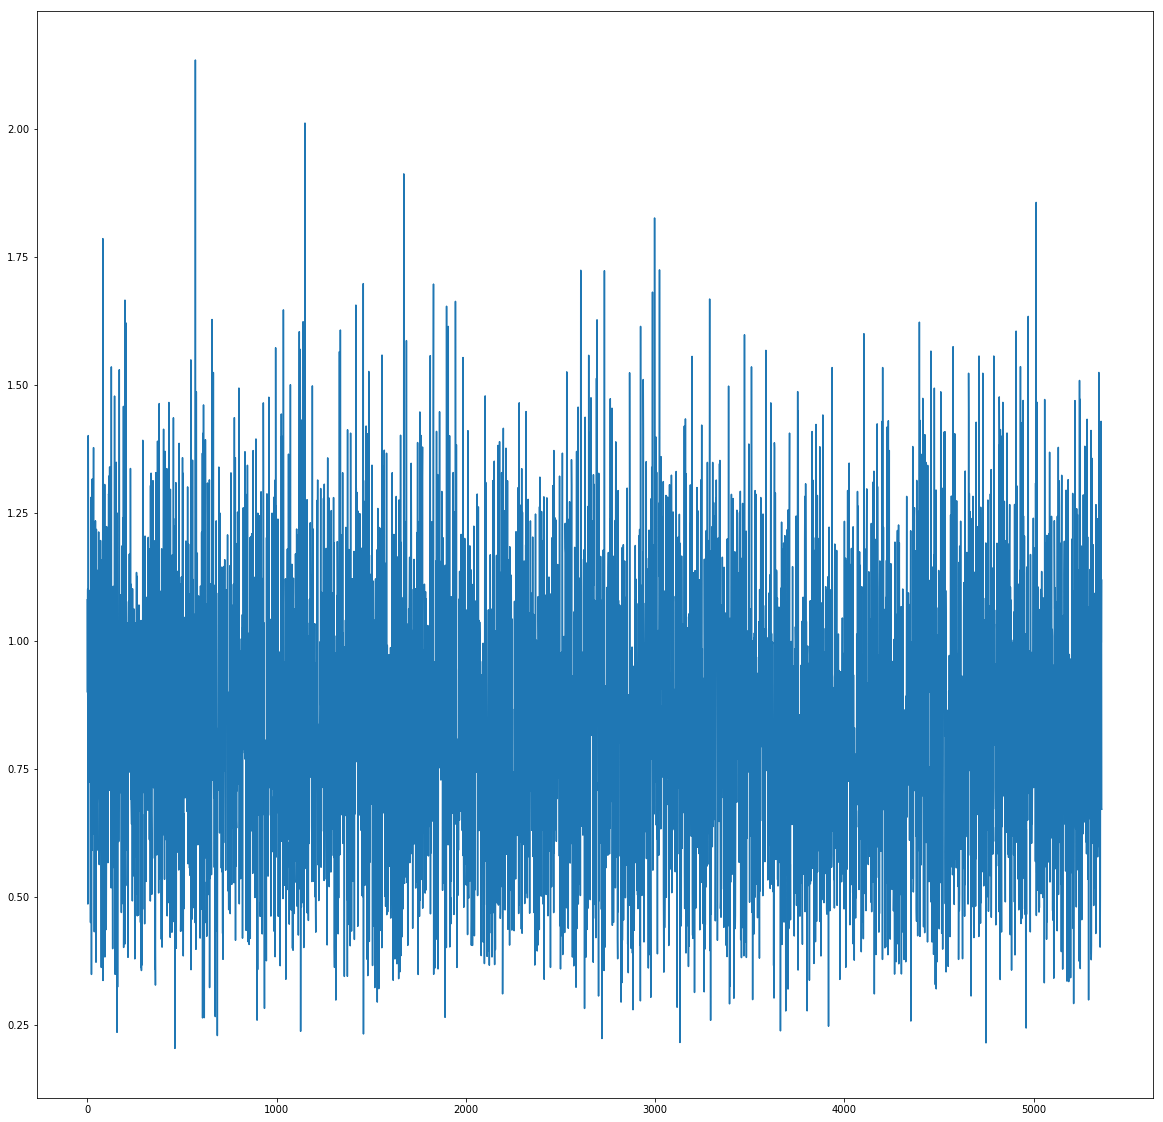

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.plot(np.arange(len(a)),a)
plt.show()

In [31]:
a

array([103.54409   , 122.58523   , 118.10599   , ...,   0.38861454,
         0.15653642,   0.46808937], dtype=float32)